# D2 Lab 3: Tensorflow Lab
## Contents:

In this project we will
1. Use `Tensorflow` to build a simple classification model
2. Get familiar with the `tensorflow.lite` module. Tensorflow Lite, or in short, TFLite optimizes the Tensorflow's computational graphs for efficiency. From the user perspective, this simplification comes with some differences of method invocation, which we will learn.
3. Deployment time! The optimized model in `tflite` format will be deployed to a NiclaVision. We will use a simplified method instead of directly working with TFLM: We are going to use EdgeImpulse API, which incorporates the TFLM and other software. It is simpler this way!
4. And of course, some wireless networking (MQTT) will be added!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from sklearn.model_selection import train_test_split # for data shuffling

## PART 1: A sample project in TensorFlow

Let's say we have some labelled data, with labels 'A' and 'B'.

In [3]:
with open("lab_data.npy", 'rb') as f:
    X = np.load(f)
    Y = np.load(f)
print("got data X:", X.shape, " labels Y:", Y.shape)

got data X: (8000, 2)  labels Y: (8000, 2)


In [4]:
dens1=X[np.where(Y==[1,0])[0]]
dens2=X[np.where(Y==[0,1])[0]]
print(dens1.shape)
print(dens2.shape)

(8000, 2)
(8000, 2)


In [5]:
binx = np.linspace(-5,5,40,endpoint=False)
biny = np.linspace(-5,5,40,endpoint=False)

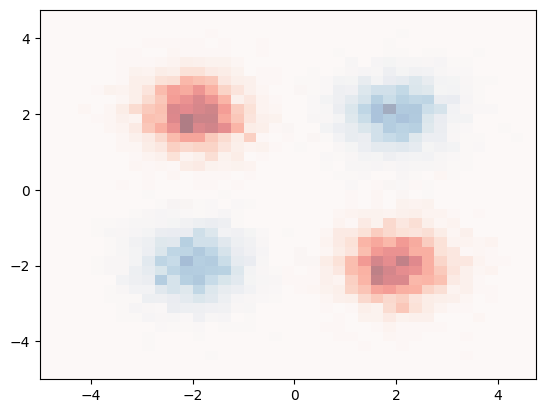

In [6]:
plt.hist2d(dens1[:,0], dens1[:,1], bins=[binx,biny], cmap='Blues', density=True, alpha=0.75)
plt.hist2d(dens2[:,0], dens2[:,1], bins=[binx,biny], cmap='Reds', density=True, alpha=0.5)
plt.show()

In [7]:
test_size=0.2 # Add yours
train_data, valid_data, train_labels, valid_labels = train_test_split(
    X, Y,
    test_size=test_size,
    shuffle=True,
    random_state=1)
print(train_data.shape)
print(train_labels.shape)

(6400, 2)
(6400, 2)


In [8]:
# Add your layer(s). Keep it simple!
model = models.Sequential(
    [
        layers.Dense(64, activation='relu', use_bias=True, input_shape=[2]),
        layers.Dense(28, activation='relu', use_bias=True),
        layers.Dense(2, activation='softmax', use_bias=True)
    ])

In [9]:
# This is important for batching!
batch_size=50
model(np.ones((batch_size,2), dtype='float'))
# Set the learning rate
learn_rate = 0.001
model.compile(
    optimizer=optimizers.Adam(learning_rate=learn_rate),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [10]:
# Replace Nones with correct values
info = model.fit(
    train_data, train_labels, batch_size=50,
    validation_data=(valid_data, valid_labels),
    shuffle=True, epochs=20, verbose=1)
h = info.history

Epoch 1/20
128/128 [==============================] - 1s 4ms/step - loss: 0.1372 - accuracy: 0.9720 - val_loss: 0.0259 - val_accuracy: 0.9956
Epoch 2/20
128/128 [==============================] - 0s 3ms/step - loss: 0.0156 - accuracy: 0.9983 - val_loss: 0.0140 - val_accuracy: 0.9950
Epoch 3/20
128/128 [==============================] - 0s 3ms/step - loss: 0.0090 - accuracy: 0.9984 - val_loss: 0.0115 - val_accuracy: 0.9950
Epoch 4/20
128/128 [==============================] - 0s 3ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0104 - val_accuracy: 0.9956
Epoch 5/20
128/128 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0104 - val_accuracy: 0.9962
Epoch 6/20
128/128 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0110 - val_accuracy: 0.9956
Epoch 7/20
128/128 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0114 - val_accuracy: 0.9962
Epoch 

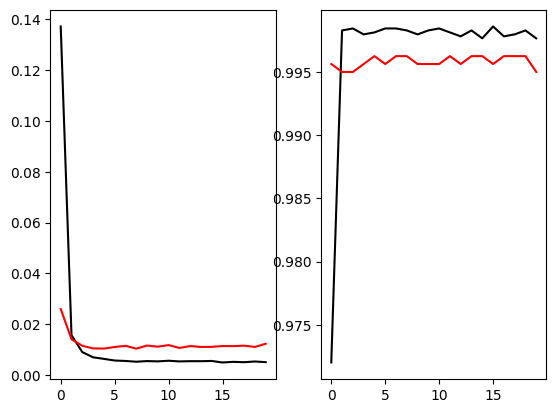

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True)
ax[0].plot(h['loss'], color='black')
ax[0].plot(h['val_loss'], color='red')
ax[1].plot(h['accuracy'], color='black');
ax[1].plot(h['val_accuracy'], color='red')
plt.show()

Here, we plot 'predictions' along two horizontal lines, one at x=2, another at x=-2

Can you see why we do that?

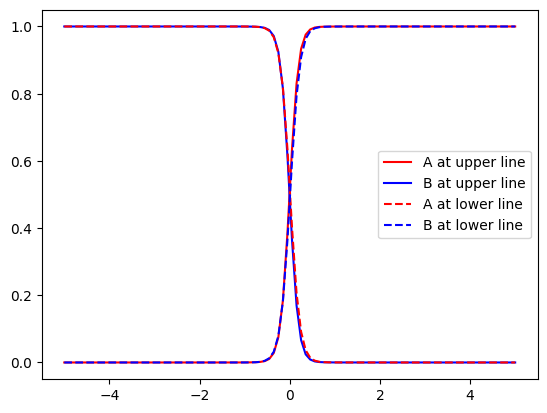

In [12]:
line1 = np.array([np.linspace(-5, 5, 100), np.tile([2.0],100)]).T
line2 = np.array([np.linspace(-5, 5, 100), np.tile([-2.0],100)]).T
ypred1 = model(line1).numpy()
ypred2 = model(line2).numpy()
plt.plot(line1[:,0], ypred1[:,0], color='red', label='A at upper line')
plt.plot(line1[:,0], ypred1[:,1], color='blue', label='B at upper line')
plt.plot(line2[:,0], ypred2[:,0], color='red', linestyle='dashed', label='A at lower line')
plt.plot(line2[:,0], ypred2[:,1], color='blue', linestyle='dashed', label='B at lower line')

plt.legend()
plt.show()

## PART 2: Computational Graphs with TFLite
We cannot deploy this Tensorflow model on a microcontroller.

Luckily, there are a variety of tools that can 'convert' the model into a form usable on microcontrollers.

In particular, Tensorflow itself has a submodule called TFLite (`tensoflow.lite`) for handling the conversion.

So the first passage from TensorFlow to micrcontrollers goes through `TFLite`.

In [13]:
mpath = "model.tflite" # Give your model a name

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec = tf.lite.TargetSpec()
m = converter.convert()

with open(mpath, 'wb') as f:
    f.write(m)

In [18]:
#####SKIP THIS PART
#interpreter = tf.lite.Interpreter(model_path=mpath)
#interpreter.allocate_tensors()
#input_shape = [2]

#xtest = tf.constant([3.0, 3.0], shape=input_shape, dtype=tf.float32)

# TensorFlow way:
#y_tf = model(xtest)
#print('with TensorFlow:', y_tf)

# TFLite (and micro) way:
#interpreter.set_tensor(0, xtest)
#interpreter.invoke()
#y_lite = interpreter.get_tensor(output_details[0]['index'])
#print('with TF Lite   :', y_lite)

## PART 3: Burning a model into a microconroller
Microcontrollers like C code. You can get away with microPython sometimes, but only non performance critical applications.

Deployment is a process of incorporating the binary model and the model operations into a C program.

The 'standard' way would be to use TensorFlow Lite (TFLite) C API.
Essentially, we need to translate to C language this chunk of code:
```{python}
interpreter.set_tensor(0, xtest)
interpreter.invoke()
ytest = interpreter.get_tensor(output_details[0]['index'])
print(ytest.numpy())
```
and all the boilerplate related to memory handling.
It's not very user friendly (have a look at some examples, there are many out there...)

We'll use a neat shortcut.

EdgeImpulse now allows loading your own `tflite` model. So we'll try this path.
What we can achieve, is that all the C code will be handled for us by EdgeImpulse.

We will only go in there to tweak it.
Again, not perfect for performance critical tasks, but good enough for us!


## Steps
- 1. Build a `tflite` model (remember; one-hot)
- 2. Import the model into EdgeImpulse
- 3. Build an Arduino Library using EdgeImpulse SDK
- 4. Import the library into Arduino IDE
- 5. Modify code to suit our needs
- 6. Compile and deploy as an ordinary Arduino sketch
- 7. Run and test!

## Edge Impulse

### Create a new EdgeImpulse project
![create a new project](assets/eimp1.png)

### Select `Upload your model`
![upload model](assets/eimp2.png)

### Find your model and select it
![browse and select model](assets/eimp3.png)


### Set the options as follows
- Model input: Other
- Model output: classification
- Labels : any (name them as you like)
![](assets/eimp4.png)

### configure your deployment as
Go to deployment, select
- Arduino library
![6](assets/eimp5.png)

### Build and download
At the end of this process we are going to get an Arduino Library written in "Edge Impulse IDE"
![7](assets/eimp6.png)

## Arduino IDE
Take any example from the `examples` folder, or start from scratch.

We will modify the provided example code, to suit our needs.
- customize input
- Add MQTT communications

### Header
We need one header from Edge Impulse.

Additionally, we add headers for wireless communications.

Note this variable: `signal_t sig`


![](assets/ino1.png)

For the setup we have to
- provide the function that gets input values
- Provide input size
![](assets/ino2.png)

The main loop is rather simple!
- A couple of lines for the inference, basically one function call.
- At the end, we make a payload from data and send a message.

![](assets/ino3.png)

To benefit from EdgeImpulse SDK, we need to look up a couple of function definitions:
- `signal_t` specifies how the input has to be provided.

![10](assets/eimp7.png)

- `ei_impulse_result_t` specifies how the output is stored.

![](assets/eimp8.png)

# Seeing the result in a notebook

Open, configure and run `client.ipynb` and see the results!
